In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime
import os
from os import listdir
from datetime import timedelta
import gzip
import shutil


In [2]:
# unzip gzfiles into files under same directory
mypath = "/Users/yunxiaoxiang/Desktop/Microstructure/cbl2/"
for file in os.listdir(mypath):
    source= mypath+file
    output= mypath+file[:-3]
    with gzip.open(source,"rb") as f_in, open(output,"wb") as f_out:
        shutil.copyfileobj(f_in, f_out)



In [3]:
def readFile(file_path,file_type):
    with open(file_path, "r") as file:
        # split data into lines 
        data = file.read().split("\n")
        processed = []
        # split by '|'
        for line in data:
            processed += [line.split("|")]
    
    df = pd.DataFrame(processed)
    
    if file_type == "quote":
        df.columns=["symbology","timestamp","exchange","bidprice",
                    "bidsize","askprice","asksize","bestbidprice",
                    "bestbidsize","bestaskprice","bestasksize"]
        # convert prices into numbers
        df["bidprice"] = pd.to_numeric(df["bidprice"])
        df["askprice"] = pd.to_numeric(df["askprice"])
        df["bestbidprice"] = pd.to_numeric(df["bestbidprice"])
        df["bestaskprice"] = pd.to_numeric(df["bestaskprice"])
        
    if file_type == "trade":
        df.columns=["symbology","date","time","price","size","exchange",
                    "saleconditions","iscorrection","iscancel","isopen",
                    "isclose"]
        df["price"] = pd.to_numeric(df["price"])
        # combine date and time to get a unified timestamp
        df["date"] = df["date"]+"T"+ df["time"]+"Z"
        df = df.rename(columns={"date":"timestamp"})
        df = df.drop(columns=["time"])
        
    # drop the last row since its nan
    df = df[:-1]
    
    #covert timestamp to datetime, including 3 possible fmt
    for i in df.index:
        try:
            df.at[i,"timestamp"] = datetime.datetime.strptime(df.at[i,"timestamp"],'%Y-%m-%dT%H:%M:%S.%fZ')
        except:
            try:
                df.at[i,"timestamp"] = datetime.datetime.strptime(df.at[i,"timestamp"],'%Y-%m-%dT%H:%M:%SZ')
            except:
                df.at[i,"timestamp"] = datetime.datetime.strptime(df.at[i,"timestamp"],'%Y-%m-%dT%H:%MZ')
    
    df = df.set_index("timestamp")
    
    # change time zone for quotes
    if file_type == "quote":
        dt = timedelta(hours=4)
        df.index = df.index - dt
        
    file.close()
    return df


In [4]:
quotes = pd.DataFrame()
trades = pd.DataFrame()
# get a list of unzipped files from the directory
file_names = [file for file in listdir(mypath) if('DS' not in file and '.gz' not in file)]

# read files and make them to dataframe
for file in file_names:
    if "NBBO" in file:
        df = readFile(mypath+file,"quote")
        quotes = pd.concat([quotes, df],sort=False)
    else:
        df = readFile(mypath+file,"trade")
        trades = pd.concat([trades, df],sort=False)

quotes = quotes.sort_index(ascending = True)
trades = trades.sort_index(ascending = True)


In [5]:
trades.to_csv(mypath+"trades.csv")
quotes.to_csv(mypath+"quotes.csv")

In [ ]:
### Problem 1.1

In [6]:
# Load data for 10.15 from 9:30 to 16:00
trades1015 = readFile(mypath+"CBL.2008-10-15","trade")
trades1015 = trades1015.loc[trades1015['exchange'] == 'N']
start = datetime.datetime.strptime("2008-10-15-09:00:00",'%Y-%m-%d-%H:%M:%S')
end = datetime.datetime.strptime("2008-10-15-16:10:00",'%Y-%m-%d-%H:%M:%S')
trades1015a = trades1015[start:end]


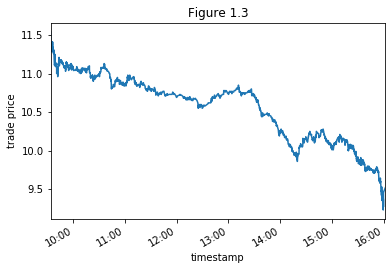

In [8]:
# change x-axis to %hour%minute format
ax=plt.gca()
myFmt = mdates.DateFormatter("%H:%M")
ax.xaxis.set_major_formatter(myFmt)
trades1015a['price'].plot()
plt.ylabel('trade price')
plt.title('Figure 1.3')
plt.show()

In [9]:
quotes1015 = readFile(mypath+"CBL-NBBO.2008-10-15","quote")
quotes1015b = quotes1015.loc[quotes1015['exchange'] == 'N']
start = datetime.datetime.strptime("2008-10-15-09:33:40",'%Y-%m-%d-%H:%M:%S')
end = datetime.datetime.strptime("2008-10-15-09:34:50",'%Y-%m-%d-%H:%M:%S')
trades1015b = trades1015[start:end]
quotes1015b = quotes1015b[start:end]

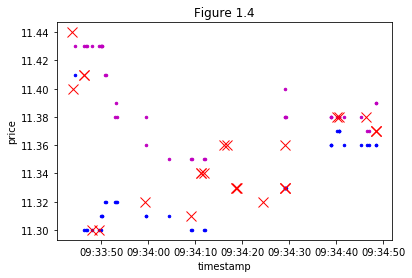

In [11]:
ax=plt.gca()
myFmt = mdates.DateFormatter("%H:%M:%S")
ax.xaxis.set_major_formatter(myFmt)
plt.plot(quotes1015b['bestbidprice'],'.',color='b',markersize=5)
plt.plot(quotes1015b['bestaskprice'],'.',color='m',markersize=5)
plt.plot(trades1015b['price'],'x',color='r',markersize=10)
plt.ylabel('price')
plt.xlabel('timestamp')
plt.title('Figure 1.4')
plt.show()

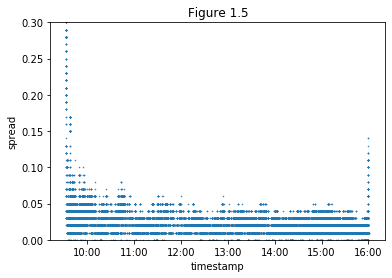

In [12]:
quotes1015c = readFile(mypath+"CBL-NBBO.2008-10-15","quote")
start = datetime.datetime.strptime("2008-10-15-09:33:00",'%Y-%m-%d-%H:%M:%S')
end = datetime.datetime.strptime("2008-10-15-16:10:00",'%Y-%m-%d-%H:%M:%S')
quotes1015c = quotes1015c.loc[start:end]
quotes1015c['spread'] = quotes1015c['bestaskprice'] - quotes1015c['bestbidprice']

ax=plt.gca()
myFmt = mdates.DateFormatter("%H:%M")
ax.xaxis.set_major_formatter(myFmt)
plt.ylim(0, 0.3)
plt.plot(quotes1015c['spread'],'.',markersize=1)
plt.ylabel('spread')
plt.xlabel('timestamp')
plt.title('Figure 1.5')
plt.show()

In [13]:
# Compute the estimated first-order autocovariance of the price changes and the implied spread in the Roll model 

trades1015 = readFile(mypath+"CBL.2008-10-15","trade")
start = datetime.datetime.strptime("2008-10-15-09:30:00",'%Y-%m-%d-%H:%M:%S')
end = datetime.datetime.strptime("2008-10-15-16:00:00",'%Y-%m-%d-%H:%M:%S')
trades1015 = trades1015[start:end]

# shift price to get dp and shift dp to get autocov of dp
trades1015["price_1"] = trades1015["price"].shift()
trades1015["dp"] = trades1015["price"] - trades1015["price_1"]
trades1015["dp_1"] = trades1015["dp"].shift()

cov = np.cov(trades1015.iloc[2:]['dp'],trades1015.iloc[2:]['dp_1'])

autocov_1 = cov[0][1]
c = np.sqrt(-autocov_1)

print("In problem 1.1: ")
print("The first-order autocov is: ",autocov_1)
print("The implied spread is: "+str(2*c))

In problem 1.1: 
The first-order autocov is:  -6.505267086376985e-05
The implied spread is: 0.016131047190281213


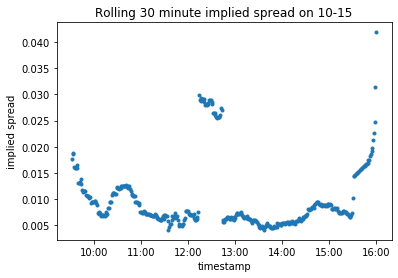

In [15]:
 # compute and plot the Roll implied spread using rolling 30-minute intervals
time = []
implied_spread = []
t = start
dt = timedelta(minutes=1)
dt_interval = timedelta(minutes=30)
while t < end:
    dp = trades1015['dp'][t:t+dt_interval]
    cov = np.cov(dp[1:],dp[:-1])
    implied_spread += [2*np.sqrt(-cov[0][1])]
    t += dt
    time += [t]


ax=plt.gca()
myFmt = mdates.DateFormatter("%H:%M")
ax.xaxis.set_major_formatter(myFmt)

plt.plot(time,implied_spread,'.')
plt.title("Rolling 30 minute implied spread on 10-15")
plt.savefig("implied_spread.jpg")
plt.xlabel('timestamp')
plt.ylabel('implied spread')
plt.show()


Yes the pattern roughly correspond to the smirk in 1.5 because the spread are higher at the begining and the end of the day. Whats different is the implied spread is high during 12-13, that might be caused by large price changes without actual spread changing too much.

In [497]:
### Problem 2.2

In [16]:
trades_n = trades.loc[trades['exchange'] == 'N'].copy()
quotes_n = quotes.loc[quotes['exchange'] == 'N'].copy()

In [17]:
def quoteTest(t,Pt,quotes):
    dt = timedelta(seconds=1)
    # look back 1 sec
    rangeToFind = quotes[t-dt:t]
    if len(rangeToFind) == 0:
        raise Exception('There was no quotes in past 1sec, quote test fails')
    elif len(rangeToFind) == 1:
        bid = rangeToFind['bidprice'][0] 
        ask = rangeToFind['askprice'][0]
    else:   
        bid = rangeToFind['bidprice'][-1] 
        ask = rangeToFind['askprice'][-1]
        
    # if price = last bid, it is classified as sell
    if np.isclose(Pt,bid,atol=1e-08):
        return "Sell"
    # if price = last ask, it is classified as buy
    elif np.isclose(Pt,ask,atol=1e-08):
        return "Buy"
    # trades at the mid that cannot be classified uniquely by the quote test. 
    else:
        raise Exception('Price was at the mid, quote test fails to classify')
    
# buy if upstick and zero upstick
def tickTest(t,Pt,trades):
    dt = timedelta(minutes = 10)
    rangeToFind = trades[t-dt:t]
    if len(rangeToFind) == 1:
        return "Cannot be identified"
        raise Exception('There was no trades in past 10 min, tick test fails')
    else:   
        lastPrice = rangeToFind['price'][-2]
        
    if lastPrice < Pt:
        return "Buy"
    elif lastPrice > Pt:
        return "Sell"
    # when last price = pt, seek for next
    else:
        i = 0
        
        while(i<len(rangeToFind['price'])-1):
            lastPrice = rangeToFind['price'][-1-i]
            if(lastPrice != Pt):
                break
            i += 1
            
        if lastPrice < Pt:
            return "Buy"
        elif lastPrice > Pt:
            return "Sell"
        else:
            return "Cannot be identified"


    
    
def classify(trades,quotes):
    trades['Buy or sell']=''
    for i in range(len(trades)):
        t = trades.index[i]
        Pt = trades['price'][i]
        try:
            trade_type = quoteTest(t,Pt,quotes)
            trades['Buy or sell'][i] = trade_type
        except:
            trade_type = tickTest(t,Pt,trades)
            trades['Buy or sell'][i] = trade_type
        


In [18]:
classify(trades_n,quotes_n)

/Users/yunxiaoxiang/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/yunxiaoxiang/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [20]:
trades_n.to_csv(mypath+"trades_with_classification.csv")

In [ ]:
# Problem 2.3

In [21]:
def GM_delta(mu,delta,order_type):
    p_buy = (-2*delta*mu+mu+1)/2
    if order_type == "Buy":
        return max(0.000001,1/2*(1-mu)*delta/p_buy)
    elif order_type == "Sell":
        return min(0.999999,(mu+1/2*(1-mu))*delta/(1-p_buy))
    else:
        return delta
    

In [22]:
mu = 0.05
delta_0 = 0.5

trades_n['delta'] = 0
trades_n.loc[trades_n.index[0],'delta'] = 0.5

index = 0
for t in trades_n.index[1:]:
    lastdelta = trades_n['delta'][index]
    order_type = trades_n['Buy or sell'][index+1]
    trades_n.loc[t,'delta'] = GM_delta(mu,lastdelta, order_type)
    index += 1


In [23]:
trades_n.to_csv(mypath+"trades_with_delta.csv")

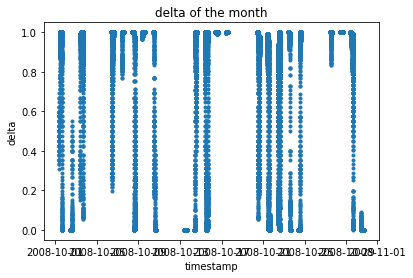

In [24]:
#plot the delta time series
plt.plot(trades_n['delta'],'.')
plt.xlabel('timestamp')
plt.ylabel('delta')
plt.title("delta of the month")
plt.savefig("delta.jpg")
plt.show()

In [25]:
!jupyter nbconvert --to script mmhw1_yunxiaoxiang.ipynb

[NbConvertApp] Converting notebook mmhw1_yunxiaoxiang.ipynb to script
[NbConvertApp] Writing 10331 bytes to mmhw1_yunxiaoxiang.py
